In [1]:
import pints
import pints.toy
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
model = pints.toy.FitzhughNagumoModel()

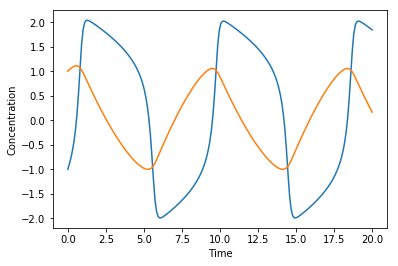

In [2]:
# Run the same simulation using our new model wrapper
times = np.linspace(0, 20, 200)
values = model.simulate([0.1,0.1,3], times)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values)


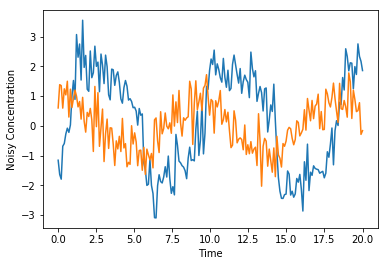

In [3]:
# Define the 'true' parameters
true_parameters = [0.1, 0.1, 3.]

# Run a simulation to get test data
values = model.simulate(true_parameters, times)

# Add some noise
sigma = 0.5
values = values + np.random.randn(values.shape[0],values.shape[1])*sigma

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Noisy Concentration')
plt.plot(times, values)

In [5]:
# Create an object with links to the model and time series
problem = pints.MultiSeriesProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

Minimising error measure
using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      970.5306   0:00.0
1     14     936.7938   0:00.0
2     21     513.193    0:00.1
3     28     513.193    0:00.1
20    147    103.9541   0:00.8
40    287    98.01752   0:02.2
60    427    97.67167   0:03.6
80    567    97.57288   0:05.1
100   707    97.57198   0:06.5
120   847    97.57197   0:07.9
140   987    97.57197   0:09.3
160   1127   97.57197   0:10.7
180   1267   97.57196   0:12.2
200   1407   97.57196   0:13.7
220   1547   97.57196   0:15.3
240   1687   97.57196   0:16.8
260   1827   97.57196   0:18.3
280   1967   97.57196   0:19.9
300   2107   97.57196   0:21.3
320   2247   97.57196   0:22.8
340   2387   97.57196   0:24.2
360   2527   97.57196   0:25.7
370   2590   97.57196   0:26.3
Halting: No significant change for 200 iterations.
Score at true solution:
97.7359406826
Found solution:          True parameters:
 

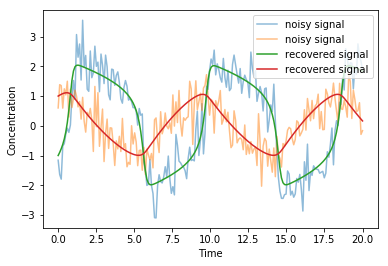

In [6]:
boundaries = pints.Boundaries([0., 0., 0.], [10., 10., 10.])

# Select a starting point
x0 = [1, 1, 1]

# Perform an optimization using SNES (see docs linked above). 
found_parameters, found_value = pints.optimise(score, x0, boundaries=boundaries, method=pints.XNES)
print('Score at true solution:')
print(score(true_parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values, alpha=0.5, label='noisy signal')
plt.plot(times, problem.evaluate(found_parameters), label='recovered signal')
plt.legend()
plt.show()

In [7]:
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0],
    [2., 2., 10., 5.]
)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [8]:
found_parameters = np.hstack((found_parameters,sigma))


In [10]:
# Choose starting points for 3 mcmc chains
xs = [
    found_parameters * 1.1,
    found_parameters * 0.9,
    found_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_adaptation_free_iterations(1000)

# Disable verbose mode
#mcmc.set_log_to_screen(False)

True

In [11]:
# Run!
print('Running...')
chains = mcmc.run()
print('Done!')


Running...
Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.1
2     9      0         0.333     0.333      0:00.1
3     12     0.25      0.25      0.25       0:00.1
20    63     0.143     0.238     0.19       0:00.6
40    123    0.0732    0.122     0.146      0:01.1
60    183    0.147541  0.0984    0.164      0:01.7
80    243    0.123     0.0741    0.123      0:02.3
100   303    0.139     0.0693    0.099      0:02.9
120   363    0.116     0.0661    0.0826     0:03.4
140   423    0.0993    0.0567    0.078      0:03.9
160   483    0.087     0.0559    0.0745     0:04.5
180   543    0.0773    0.0608    0.0663     0:05.0
200   603    0.0697    0.0597    0.0647     0:05.6
220   663    0.0633    0.0543    0.0679     0:06.2
240   723    0.0622    0.0498    0.0705     0:06.9
260   783    0.0575    0.046     0.069    

3100  9303   0.213     0.205     0.212      1:30.4
3120  9363   0.215     0.207     0.212      1:30.9
3140  9423   0.216     0.208     0.212      1:31.4
3160  9483   0.216     0.208     0.212      1:31.8
3180  9543   0.216     0.208     0.213      1:32.3
3200  9603   0.215     0.208     0.214      1:32.8
3220  9663   0.216     0.21      0.215      1:33.3
3240  9723   0.217     0.21      0.215      1:33.8
3260  9783   0.216498  0.211     0.217      1:34.2
3280  9843   0.216     0.213     0.217      1:34.7
3300  9903   0.216601  0.214     0.217      1:35.2
3320  9963   0.217     0.213791  0.218      1:35.6
3340  10023  0.217     0.214     0.218      1:36.0
3360  10083  0.216     0.214817  0.219      1:36.5
3380  10143  0.216504  0.215     0.219      1:36.9
3400  10203  0.218     0.215     0.22       1:37.4
3420  10263  0.218     0.215     0.219      1:37.8
3440  10323  0.218     0.215     0.219413   1:38.3
3460  10383  0.22      0.215     0.22       1:38.8
3480  10443  0.220339  0.215   

R-hat:
[1.0072677236957825, 1.0219692988472944, 1.0106888745187563, 1.0089021869746584]


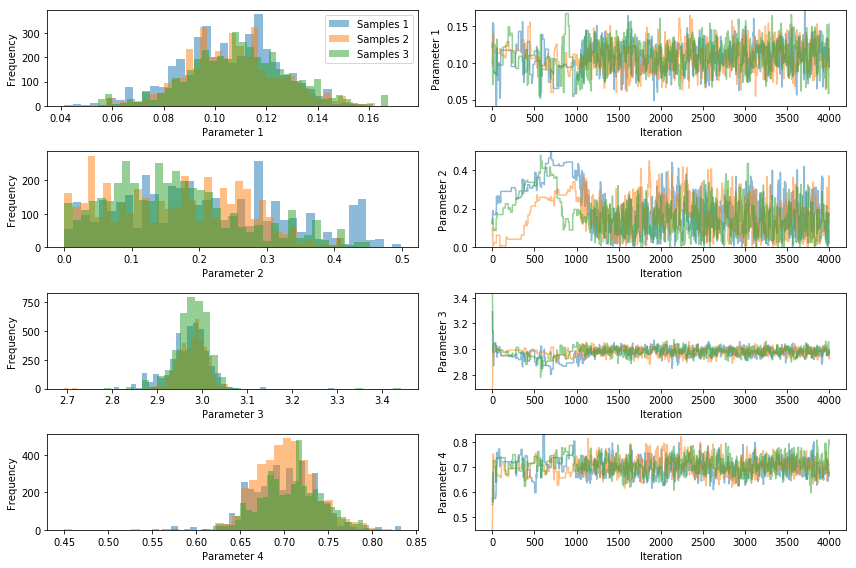

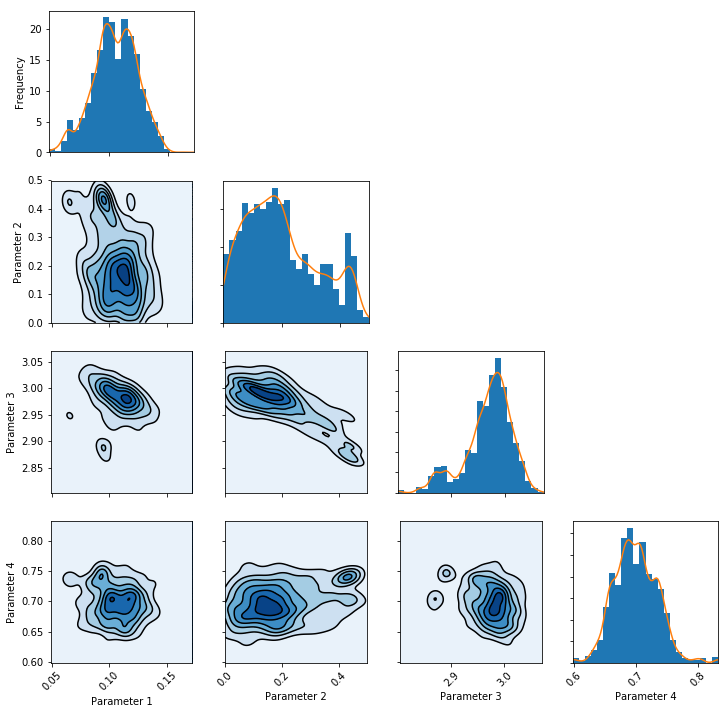

In [12]:
import pints.plot
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 500:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()